# Tree based models

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn import tree
import xgboost as xgb #pip3 install xgboost
import pickle
from sklearn.tree import plot_tree
from xgboost import plot_tree
from sklearn.tree import export_graphviz
from xgboost import plot_importance
import warnings

#Setting seed for replicability 
seed = 500

#Turing off the warnings
warnings.filterwarnings('ignore')

In [4]:
#Loading the data - from previous code 
df_cleaned = pd.read_csv('data_cleaned.csv')
df_cleaned.dtypes

#Selecting columns for the model 
#We selected numerical variables and categorical variables with a maximum
#of 4 categories for easier computation. We also considered the importance of variables
#(for example, host ID is not relevant).

df_model = df_cleaned[["Lprice","host_response_rate","host_acceptance_rate","accommodates","beds",
                       "minimum_nights","maximum_nights","availability_90","review_scores_rating",
                        "calculated_host_listings_count","reviews_per_month","Hotel room","Private room","Shared room","bathrooms_cislo",
                        "5 to 10","less than 5","host_response_time_within a day","host_response_time_within a few hours",
                        "host_response_time_within an hour","neighborhood_overview_1","host_location_1",
                        "host_about_1","host_is_superhost_t","host_has_profile_pic_t","host_identity_verified_t","has_availability_t","instant_bookable_t"]]


#Defining feature names for explanatory variables for the graphs
feature_names = ["host_response_rate","host_acceptance_rate","accommodates","beds",
                       "minimum_nights","maximum_nights","availability_90","review_scores_rating",
                        "calculated_host_listings_count","reviews_per_month","Hotel room","Private room","Shared room","bathrooms_cislo",
                        "5 to 10","less than 5","host_response_time_within a day","host_response_time_within a few hours",
                        "host_response_time_within an hour","neighborhood_overview_1","host_location_1",
                        "host_about_1","host_is_superhost_t","host_has_profile_pic_t","host_identity_verified_t","has_availability_t","instant_bookable_t"]

#Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    df_model.drop(['Lprice'], axis=1),  
    df_model[['Lprice']],  
    test_size=0.2,  
    random_state=seed
)



#### First model - Random forest regressor without CV

0.47435165932956125


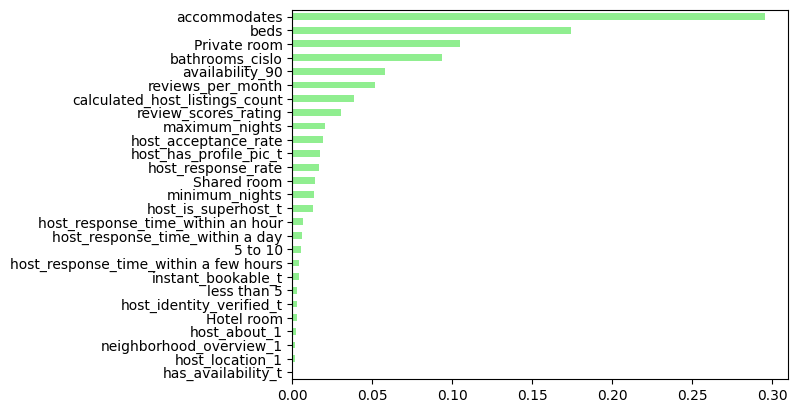

accommodates         0.295251
beds                 0.174381
Private room         0.104589
bathrooms_cislo      0.093506
availability_90      0.057985
reviews_per_month    0.051684
dtype: float64


In [5]:
#Defining the first model - without crossvalidation, just hold out validation
random_forest_model = RandomForestRegressor(n_estimators = 100, #number of trees
                                             min_samples_split = 0.05,
                                             max_features = 4,
                                             random_state = seed)
 
#Training the model
random_forest_model.fit(x_train, y_train.values.ravel())
#Predict values for the x_test set
y_pred = random_forest_model.predict(x_test)
#Evaluate the test set RMSE
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_test) #This model's RMSE is 0,474

r2=r2_score(y_test, y_pred)
r2

#Defining the residuals
residuals_1 = y_test.values.ravel() - y_pred

#Impurity based importances for the first model
#calculation of feature importance
importances_rf = pd.Series(random_forest_model.feature_importances_, index = x_train.columns)
#sorting
sorted_importances_rf = importances_rf.sort_values()
#plotting into bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen') 
plt.show()

#which features are the most important? Cutoff 0.05
print(sorted_importances_rf[sorted_importances_rf > 0.05].sort_values(ascending=False))


We can see that the first forest model puts features such as accomodates, beds, private room,
bathrooms_cislo, availibility_90 and reviews_per_month as the most important via impurity measures.


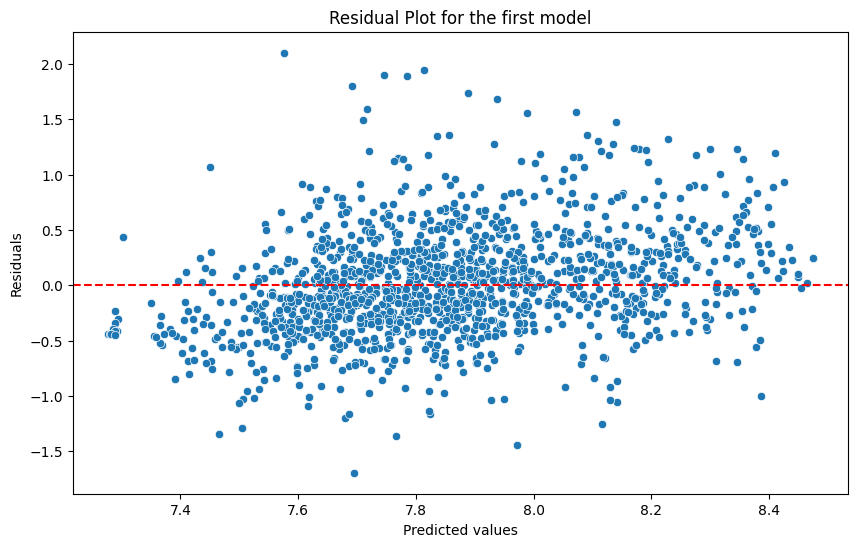

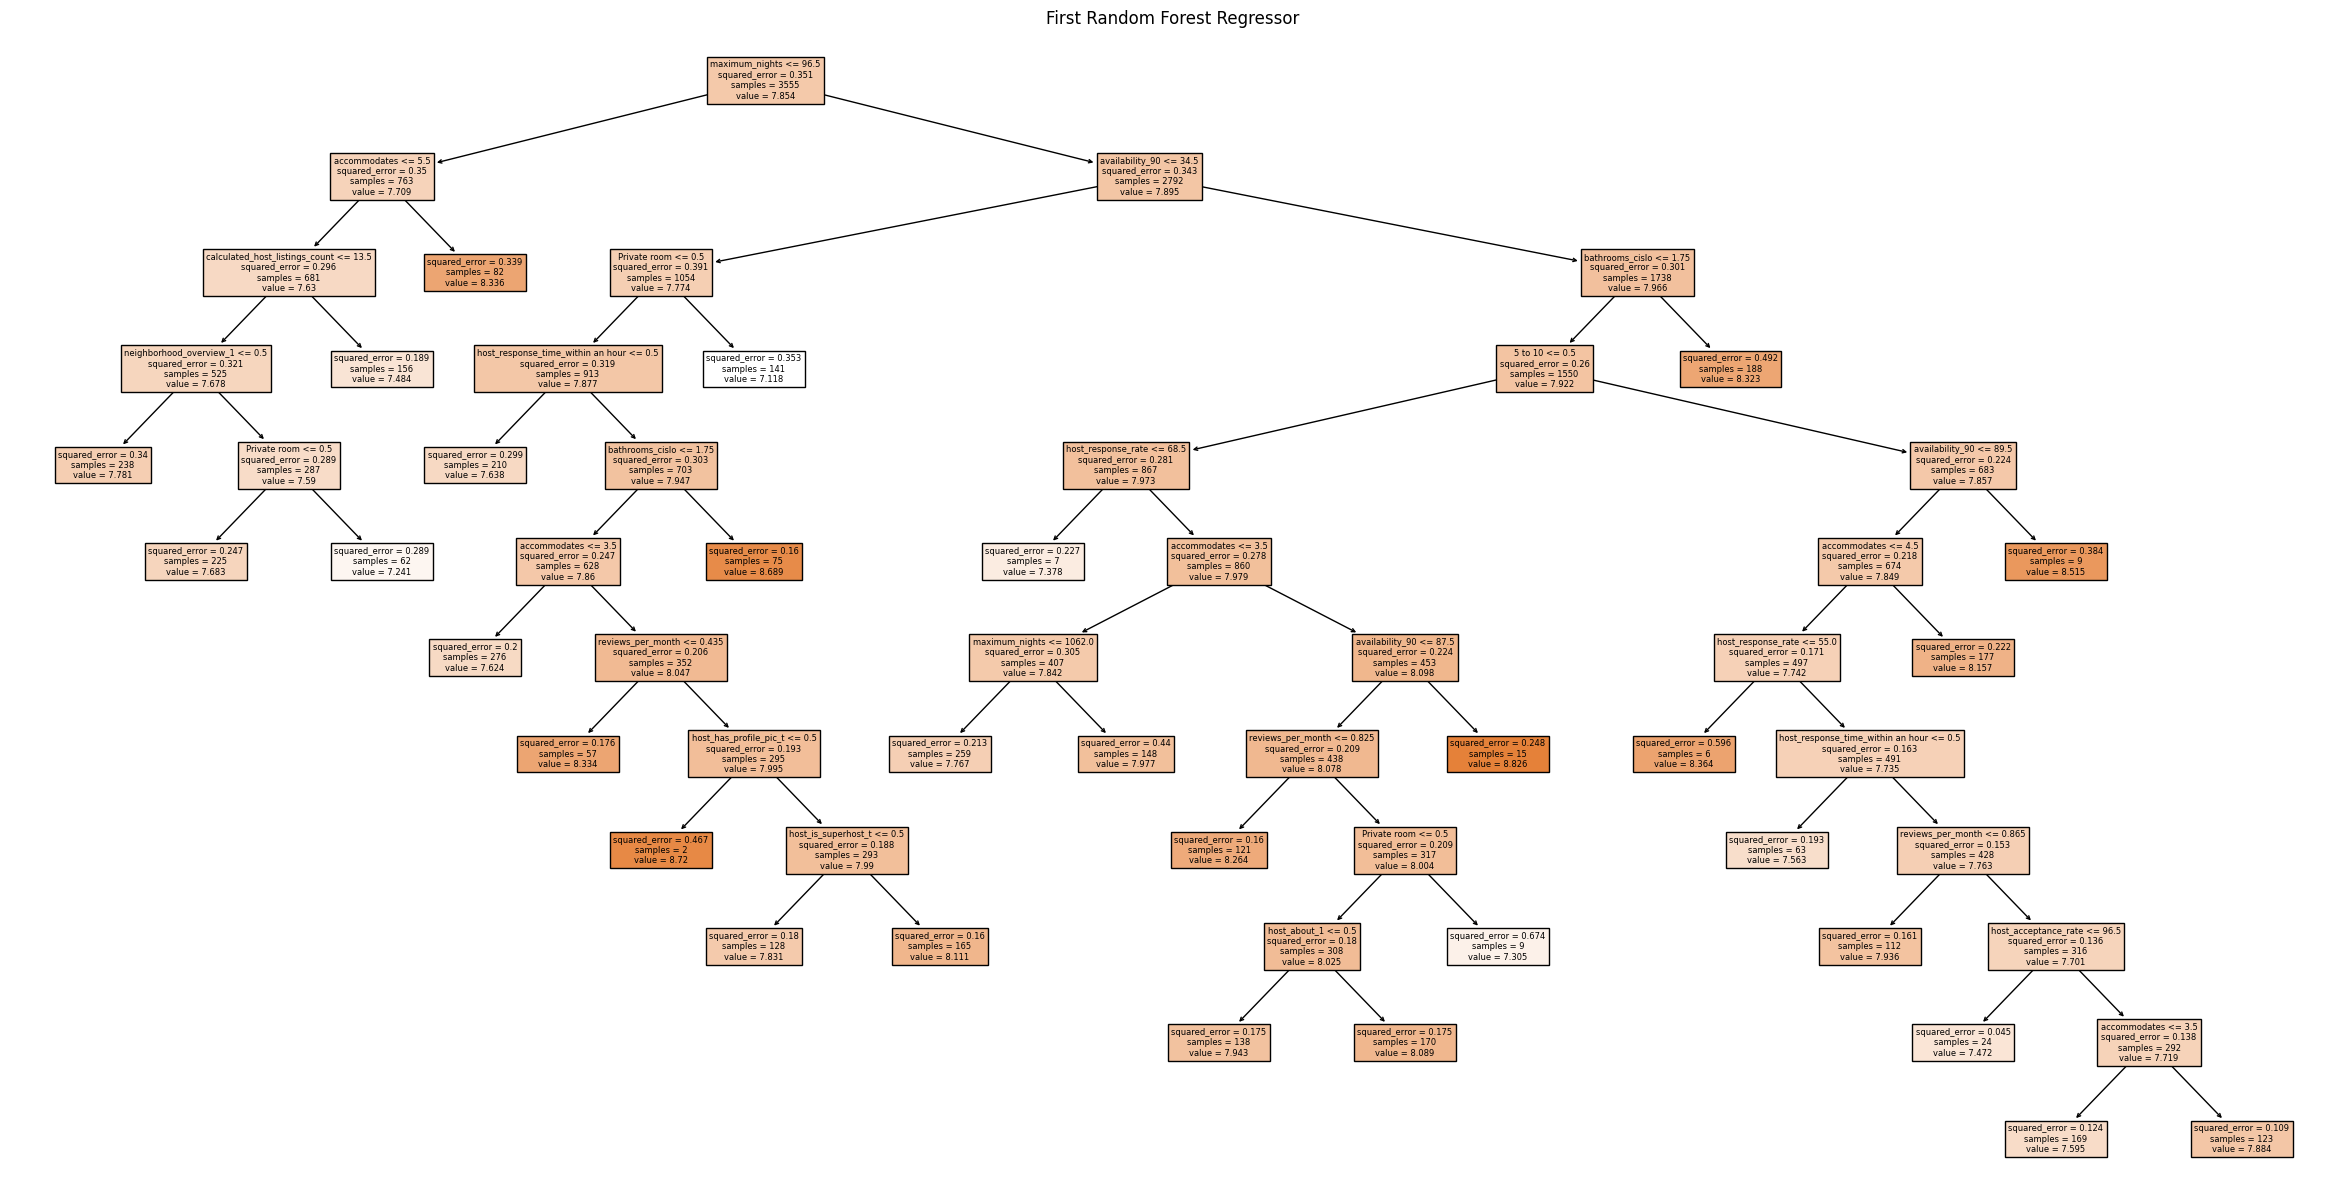

In [6]:
#Plotting the predicted values vs residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals_1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for the first model')
plt.show()

#Plot of the first forest model, without CV
plt.figure(figsize=(30, 15))
tree.plot_tree(random_forest_model.estimators_[0], filled=True, feature_names=feature_names)
plt.title('First Random Forest Regressor')
plt.show()

In this tree, we will demonstrate how the decision-making algorithm works. The root of this tree is the variable minimum_nights, for which the Split point is 96.5 nights, where for lower values, the next criterion chosen was the variable accommodates. If it reaches a value higher than 5.5, then the final price for the listing is 4171 CZK per night. If the value were lower, the next Split criterion would be calculated_host_listings_count

#### Second model - Random forest optimised by CV

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_features=4, min_samples_split=10, n_estimators=3000; total time=  31.6s
[CV] END max_features=4, min_samples_split=10, n_estimators=3000; total time=  31.7s
[CV] END max_features=4, min_samples_split=10, n_estimators=3000; total time=  31.7s
[CV] END max_features=4, min_samples_split=10, n_estimators=5000; total time=  59.4s
[CV] END max_features=4, min_samples_split=20, n_estimators=3000; total time=  34.7s
[CV] END max_features=4, min_samples_split=20, n_estimators=3000; total time=  26.3s
[CV] END max_features=4, min_samples_split=10, n_estimators=5000; total time=  58.6s
[CV] END max_features=4, min_samples_split=10, n_estimators=5000; total time=  58.9s
[CV] END max_features=4, min_samples_split=20, n_estimators=3000; total time=  26.8s
[CV] END max_features=4, min_samples_split=20, n_estimators=5000; total time=  45.2s
[CV] END max_features=4, min_samples_split=20, n_estimators=5000; total time=  44.5s
[CV]

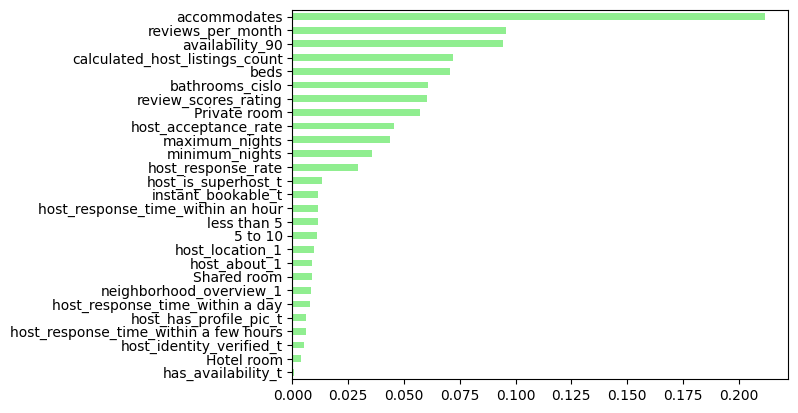

accommodates                      0.211728
reviews_per_month                 0.095614
availability_90                   0.094461
calculated_host_listings_count    0.071843
beds                              0.070776
bathrooms_cislo                   0.060857
review_scores_rating              0.060349
Private room                      0.057334
dtype: float64


In [7]:
#creating the grid for hyperparameters
hyper_grid = {'n_estimators': [3000,5000], # number of trees
               'max_features': [4,8,9], #number of variables randomly sampled as candidates at each split
               'min_samples_split': [10, 20], #the minimum number of samples required to split an internal nod
               } 

#Defining the second model with empty parameter set
forest_model_cv = RandomForestRegressor(random_state=seed)

#Launching the GridSearchCV with forest_model_cv as estimator
grid_search = GridSearchCV(estimator = forest_model_cv, param_grid = hyper_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#Fitting the grid search to the data
grid_search.fit(x_train, y_train.values.ravel())

#Best parameters for the model chosen by the grid search
print(grid_search.best_params_)
#Best parameters are: max features 8, min samples split 10 and 3000 trees (estimators)

#Defining the best estimator with the previously acquired best parameters
forest_model_opt= grid_search.best_estimator_ 

#Predict values for the x_test set
y_pred_cv = forest_model_opt.predict(x_test)

#Evaluate the RMSE
rmse_test_cv = mean_squared_error(y_test, y_pred_cv, squared=False)
print(rmse_test_cv) #This model's RMSE is 0,404

#Comparison with the first model (without CV)
print(rmse_test)
#The crossvalidated model is slightly better than (has lower RMSE)

r2_cv=r2_score(y_test, y_pred_cv) 
r2_cv

#Defining the residuals
residuals_2 = y_test.values.ravel() - y_pred_cv

#Impurity based importances for the second model
#calculation of feature importance
importances_rf = pd.Series(forest_model_opt.feature_importances_, index = x_train.columns)
#sorting
sorted_importances_rf = importances_rf.sort_values()
#plotting into bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen') 
plt.show()

#which features are the most important? Cutoff 0.05
print(sorted_importances_rf[sorted_importances_rf > 0.05].sort_values(ascending=False))

We can see that the second model chose these features as the most important for splitting:
accomodates, reviews_per_month, availibility_90, calculated_host_listings_count, beds,
bathroom_cislo, review_scores_rating and private room.

In conclusion the second model found more features that were above the 0.05 cutoff, however
their impurity measure was lower overall.

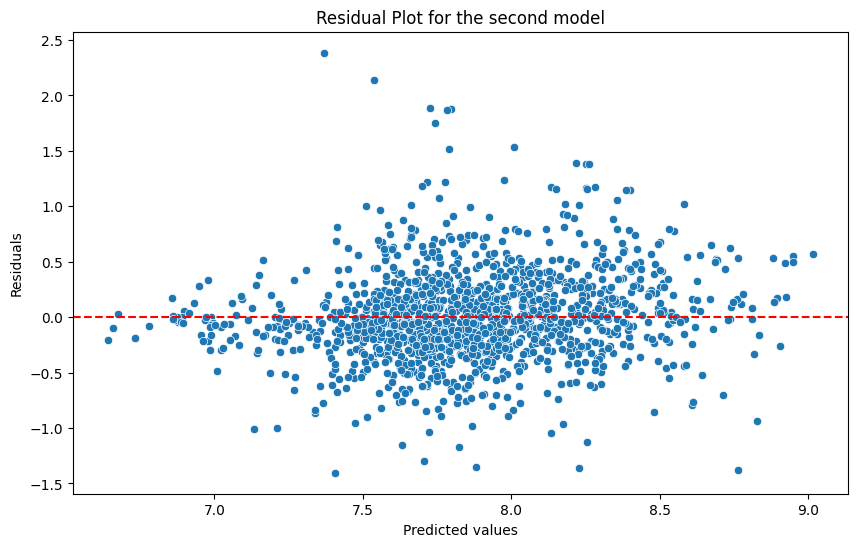

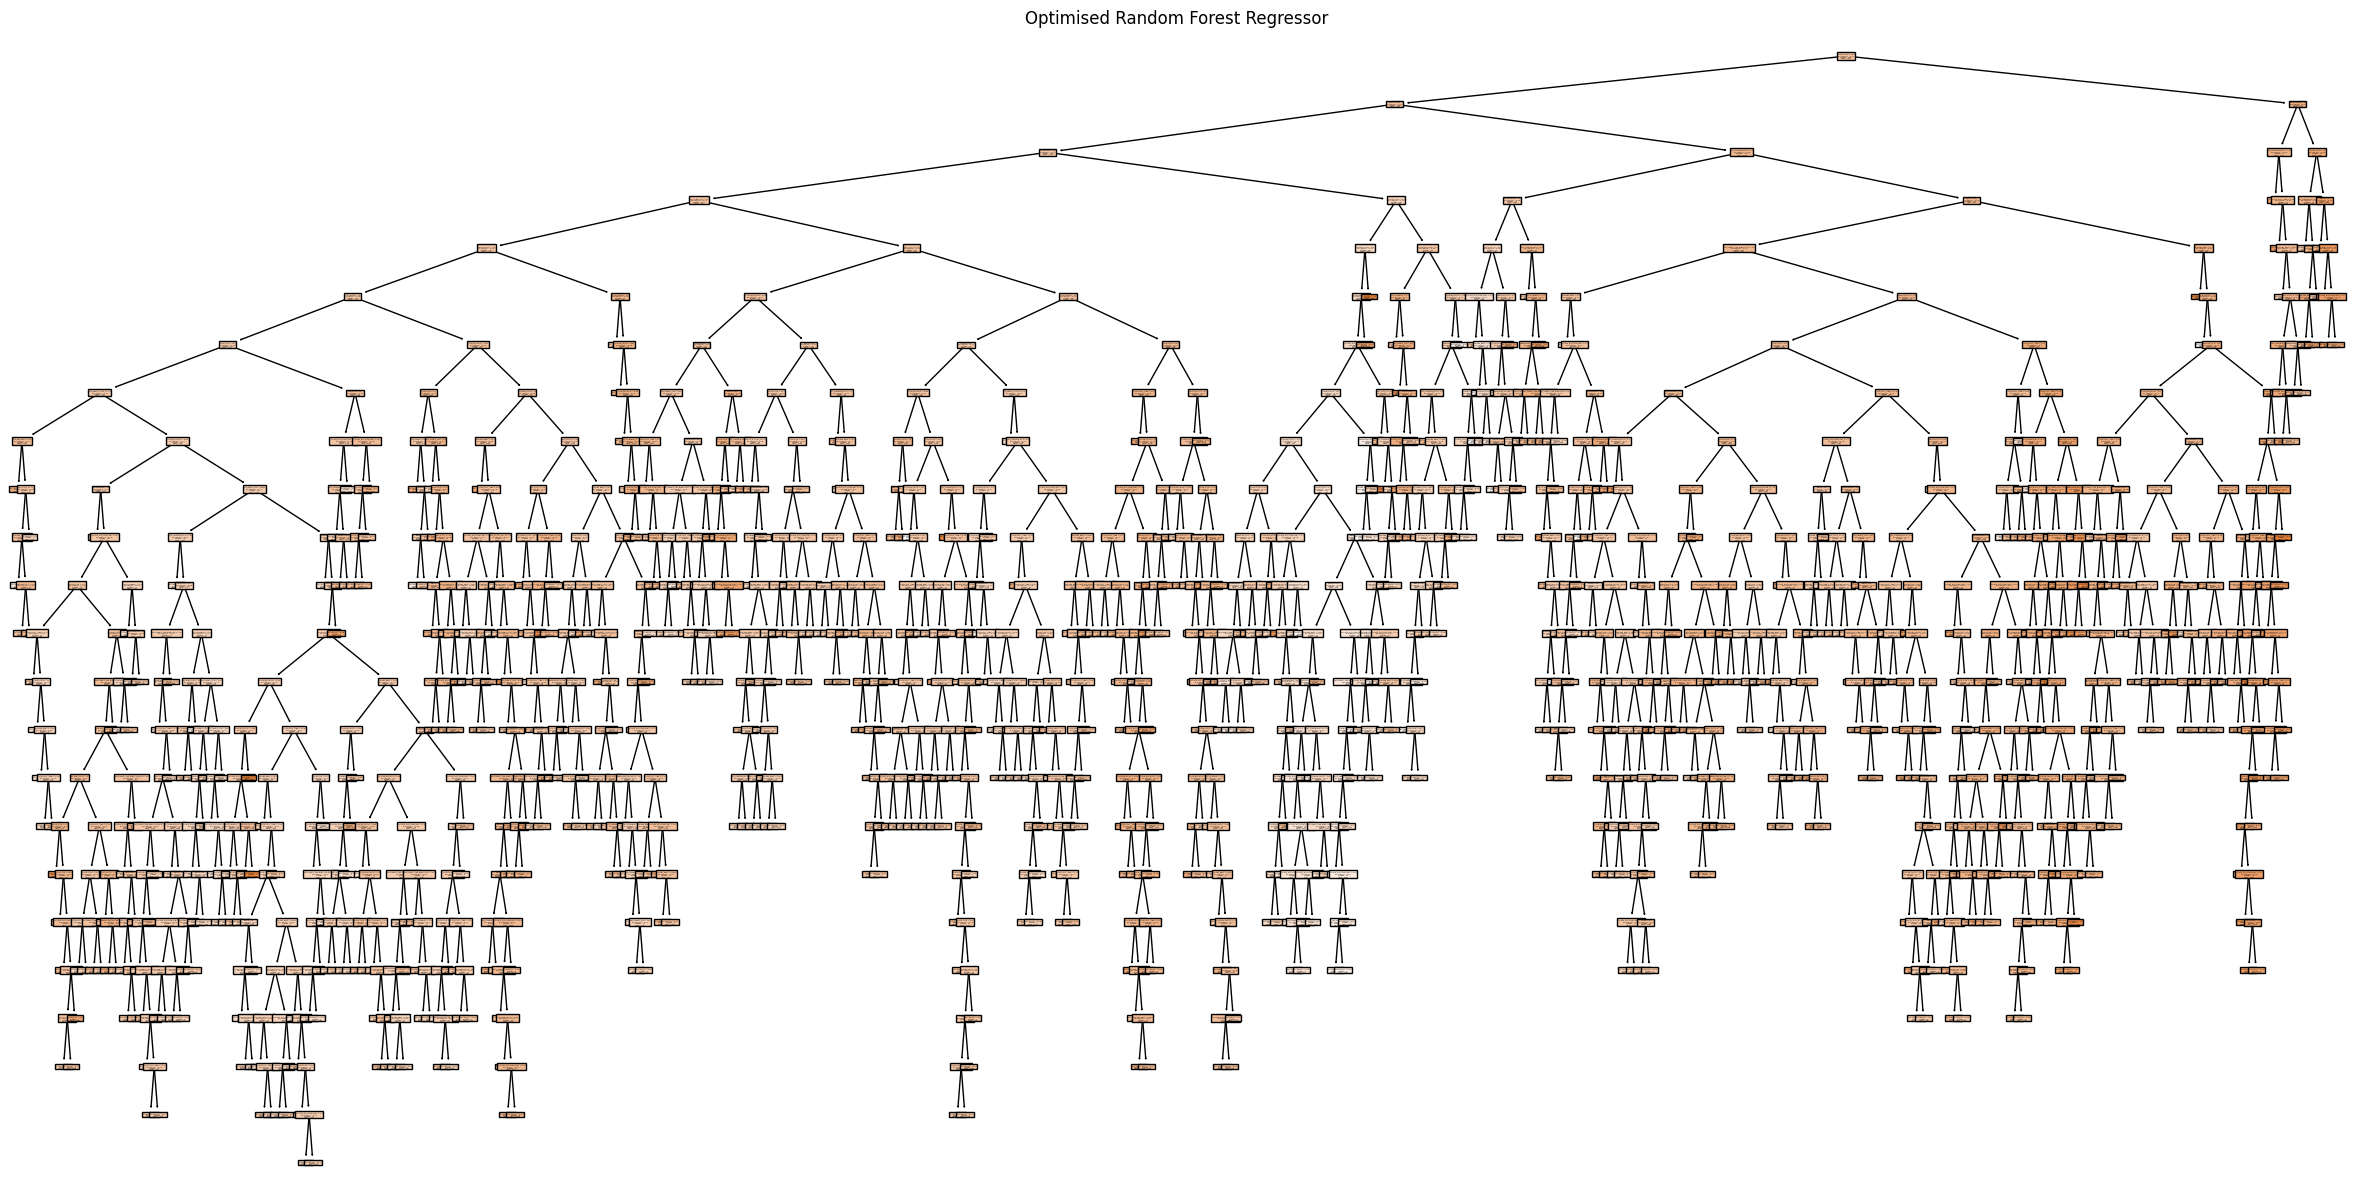

In [8]:
#Plotting the predicted values vs residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_cv, y=residuals_2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for the second model')
plt.show()

#Plot of the second forest model, with CV
plt.figure(figsize=(30, 15))
tree.plot_tree(forest_model_opt.estimators_[0], filled=True, feature_names=feature_names)
plt.title('Optimised Random Forest Regressor')
plt.show()

Even though this model is the best according to grid search, it is too complicated for interpretation and hard to read.
Therefore we create a truncated version of this model, with max depth 2 or 3 (depending on the grid search choice)

#### Model 3 - Random forest optimised by CV truncated

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_depth=2, max_features=8, min_samples_split=10, n_estimators=5000; total time=  27.8s
[CV] END max_depth=2, max_features=8, min_samples_split=10, n_estimators=5000; total time=  27.8s
[CV] END max_depth=2, max_features=8, min_samples_split=10, n_estimators=5000; total time=  27.9s
[CV] END max_depth=3, max_features=8, min_samples_split=10, n_estimators=5000; total time=  30.9s
[CV] END max_depth=3, max_features=8, min_samples_split=10, n_estimators=5000; total time=  17.6s
[CV] END max_depth=3, max_features=8, min_samples_split=10, n_estimators=5000; total time=  17.5s
{'max_depth': 3, 'max_features': 8, 'min_samples_split': 10, 'n_estimators': 5000}
0.4929809747440238


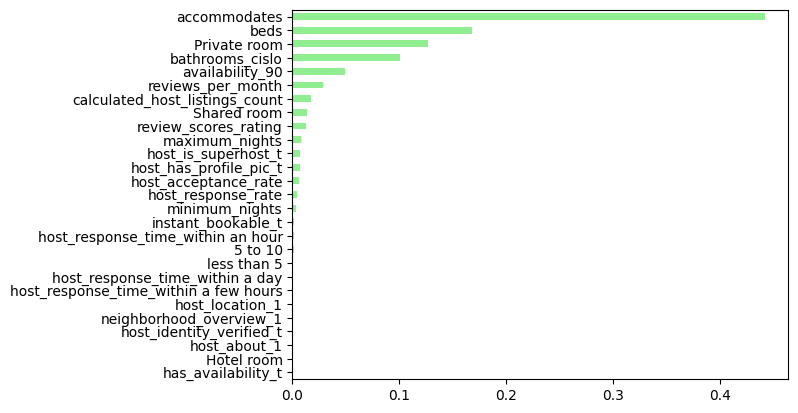

accommodates       0.442048
beds               0.168263
Private room       0.126811
bathrooms_cislo    0.100511
dtype: float64


In [9]:
#Creating the truncated model
#Create the  grid
hyper_grid_2 = {'n_estimators': [5000], # number of trees
               'max_features': [8], #number of variables randomly sampled as candidates at each split, smazáno 9
               'min_samples_split': [10], #the minimum number of samples required to split an internal node
               "max_depth":(2,3)
               } 

#Defining the second model with empty parameter set
forest_model_cv = RandomForestRegressor(random_state=seed)

#Launching the GridSearchCV with forest_model_cv as estimator
grid_search_2 = GridSearchCV(estimator = forest_model_cv, param_grid = hyper_grid_2, 
                          cv = 3, n_jobs = -1, verbose = 2)

#Fitting the grid search to the data
grid_search_2.fit(x_train, y_train.values.ravel())

#best parameters
print(grid_search_2.best_params_)

#best estimator
forest_model_opt_trunc= grid_search_2.best_estimator_ 

#Predict values for the x_test set
y_pred_cv_trunc = forest_model_opt_trunc.predict(x_test)

rmse_test_cv_trunc = mean_squared_error(y_test, y_pred_cv_trunc, squared=False)
print(rmse_test_cv_trunc) 
#We can see the truncated CV model is the worse amongs all the models, however because of its simplicity,
#its easier to read and interpret

r2_cv_trunc=r2_score(y_test, y_pred_cv_trunc)
r2_cv_trunc

#Defining the residuals
residuals_3 = y_test.values.ravel() - y_pred_cv_trunc

#Impurity based importances for the second model
#calculation of feature importance
importances_rf = pd.Series(forest_model_opt_trunc.feature_importances_, index = x_train.columns)
#sorting
sorted_importances_rf = importances_rf.sort_values()
#plotting into bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen') 
plt.show()

#which features are the most important? Cutoff 0.05
print(sorted_importances_rf[sorted_importances_rf > 0.05].sort_values(ascending=False))

We can see that the third model chose these features as the most important for splitting:
accomodates, beds, private room and bathroom_cislo.

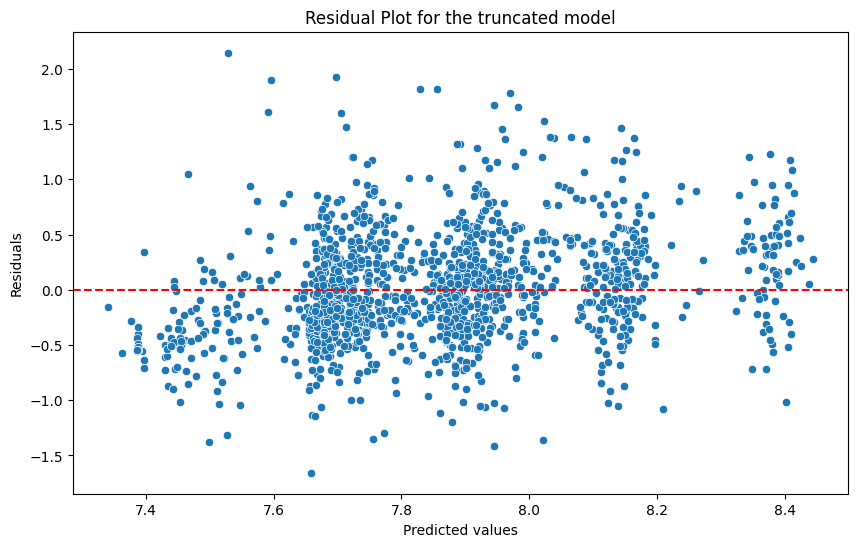

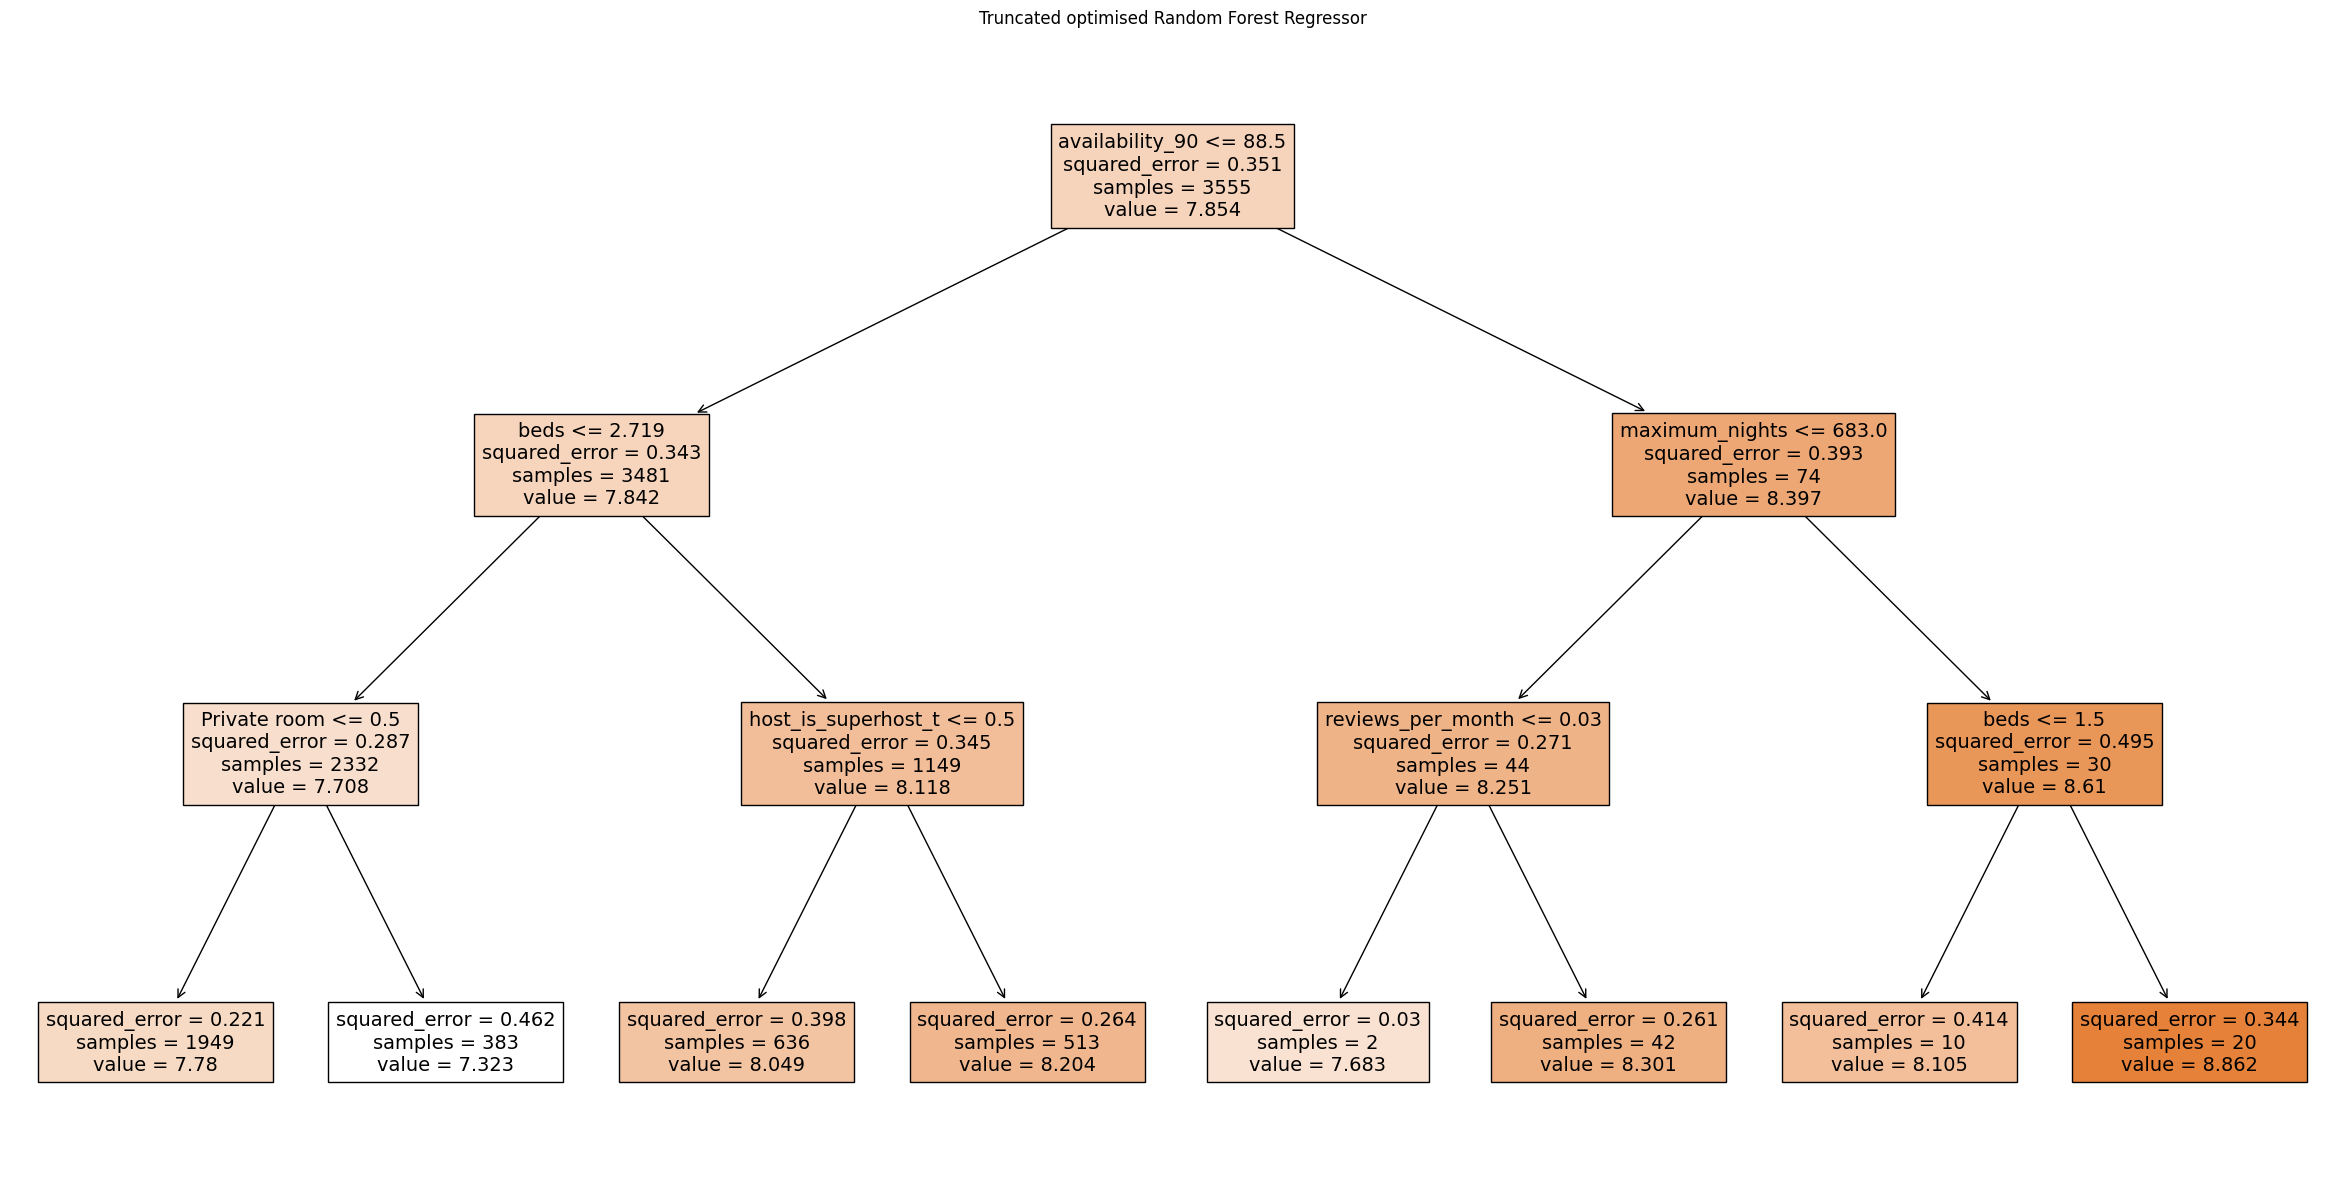

In [10]:

#Plotting the predicted values vs residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_cv_trunc, y=residuals_3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for the truncated model')
plt.show()

#Plotting the truncated cv model
plt.figure(figsize=(30, 15))
tree.plot_tree(forest_model_opt_trunc.estimators_[0], filled=True, feature_names=feature_names)
plt.title('Truncated optimised Random Forest Regressor')
plt.show()

We can see that the truncated model might be omitting way too much information, because the residuals vs predicted values show some relationship.

If we limit the number of divisions in the tree, the first dividing criterion will be availbility_90 variable. In the case of availibility being less than 88 days (out of the nex 90), the decisive factor for further division is the number of beds, otherwise, it is maximum nights.

If the accomodation is available for less than 88 days, less than 3 beds there and it is not a private room, then the price of the listing will be 2392 CZK per night. 

#### Model 4 - XGBoost model without CV

0.41131691289706035


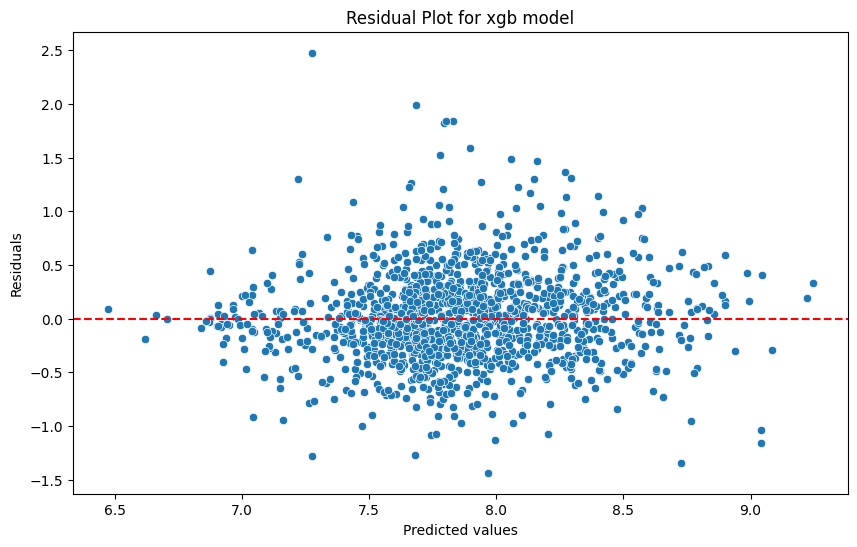

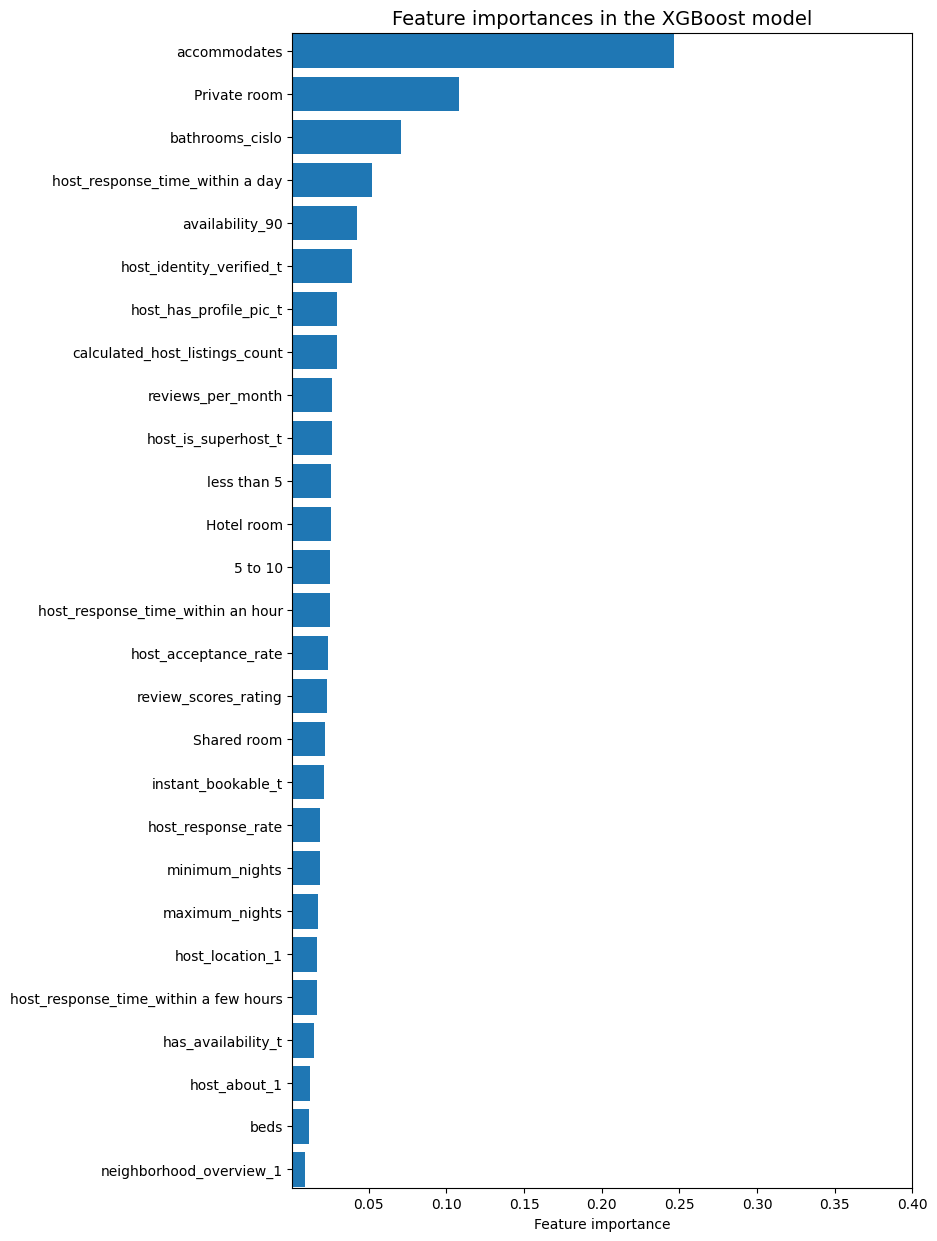

                                   weight
accommodates                     0.246409
Private room                     0.108445
bathrooms_cislo                  0.070527
host_response_time_within a day  0.052127


In [11]:
#Creating an XGBoost model without CV
gxb_model = xgb.XGBRegressor(n_estimators = 50, learning_rate = 0.1, objective='reg:squarederror',seed = seed)


from xgboost import XGBRegressor, plot_tree
from sklearn.model_selection import GridSearchCV

#Fitting the model
gxb_model.fit(x_train, y_train)

#Make predictions on the test data
y_pred_xg = gxb_model.predict(x_test)

#Evaluate the test set RMSE
rmse_xgb = mean_squared_error(y_test, y_pred_xg, squared=False)
print(rmse_xgb)

#which features are the most important?
ft_weights_xgb_reg = pd.DataFrame(gxb_model.feature_importances_, columns=['weight'], index=x_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

#R2 score
r2_xgb=r2_score(y_test, y_pred_xg)
r2_xgb

#Defining the residuals
residuals_4 = y_test.values.ravel() - y_pred_xg

#Plotting the predicted values vs residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xg, y=residuals_4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for xgb model')
plt.show()

#Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.001)
plt.xlim(0.001, 0.4)
plt.show()

#which features are the most important? Cutoff 0.05
xbg_sorted=ft_weights_xgb_reg.sort_values('weight',ascending=False)
print(xbg_sorted[xbg_sorted['weight'] > 0.05])

We can see that the most influential features by this model are accomodates, private room, bathrooms_cislo and
host_response_within a day. Only those features surpassed the 0.05 cutoff.

#### Model 5 - XGBoost model with CV

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1}
Lowest RMSE found:  0.3903444395698112
0.39479163882023227


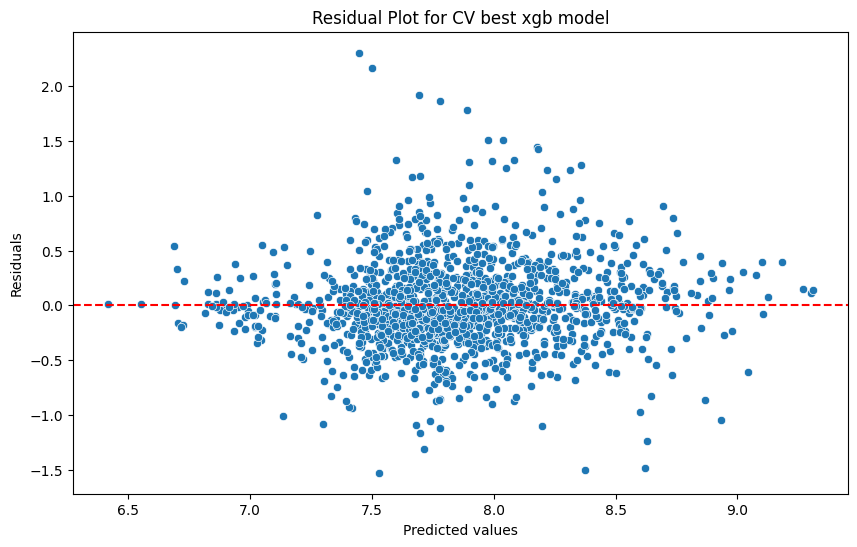

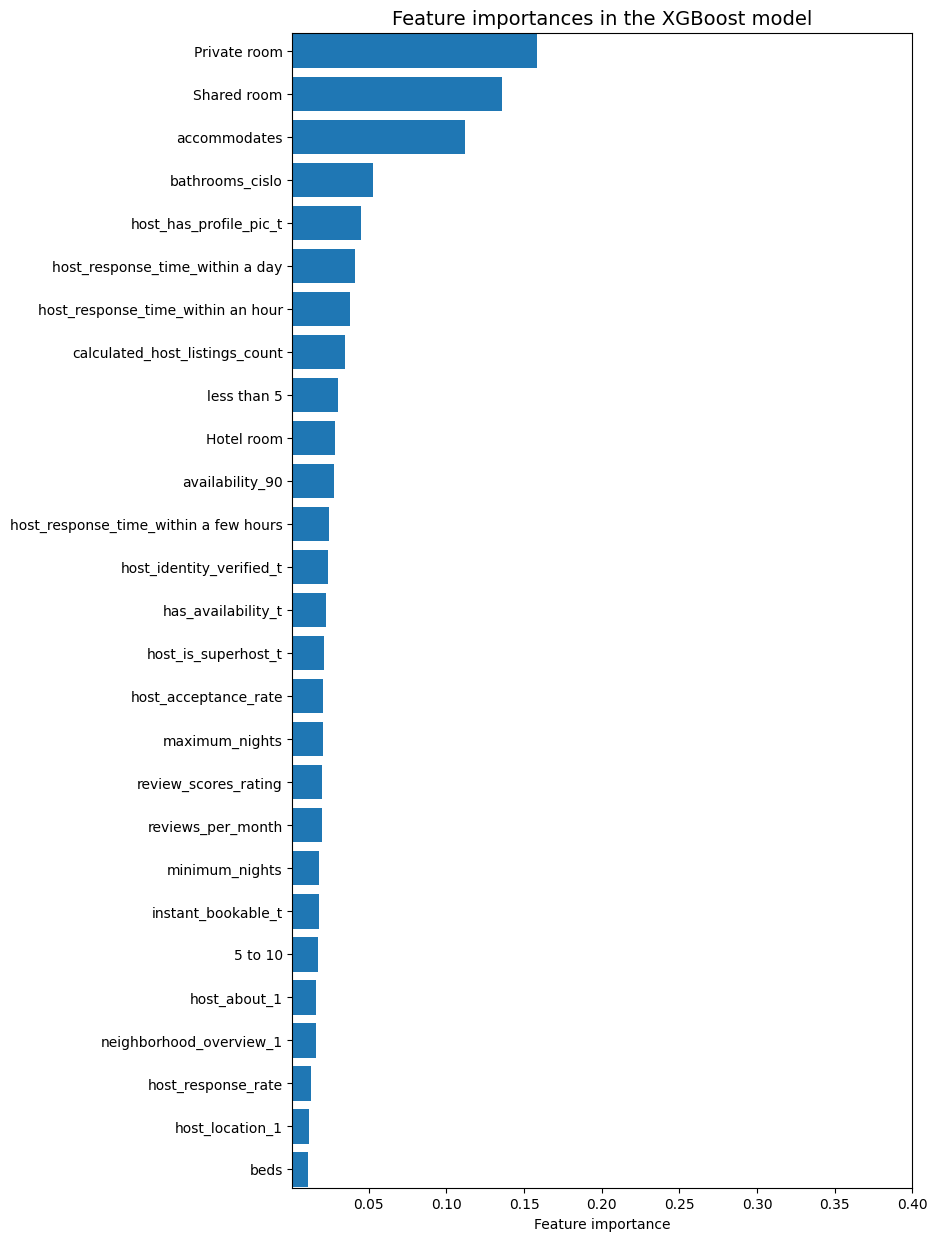

                   weight
Private room     0.158154
Shared room      0.135975
accommodates     0.112156
bathrooms_cislo  0.053098


In [12]:
#setup params grid
param_grid = {'learning_rate': [0.01,0.1,0.5], #alias eta, Step size shrinkage used in update to prevents overfitting.  
    'n_estimators': [20, 50, 100],
    'subsample': [0.5, 0.8, 1], #Subsample ratio of the training instances
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.5, 1] #colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    }

#Creating an XGBoost model with CV
gbm = xgb.XGBRegressor(seed=seed, objective='reg:squarederror')
xgb_cv = GridSearchCV(estimator=gbm,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1)
#Fitting the model
xgb_cv.fit(x_train, y_train)
#optimise by lowest RMSE

print("Best parameters found: ",xgb_cv.best_params_) #best_params_
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb_cv.best_score_))) #best_score_

#extract the estimator best_estimator_ 
xgb_cv_best = xgb_cv.best_estimator_ #best_estimator_

#Make predictions on the test data
y_pred_xg_best = xgb_cv_best.predict(x_test)

#Evaluate the test set RMSE
rmse_xgb_best = mean_squared_error(y_test, y_pred_xg_best, squared=False)
print(rmse_xgb_best)

#R2 score
r2_xgb_cv_best=r2_score(y_test, y_pred_xg_best)
r2_xgb_cv_best

#Defining the residuals
residuals_5 = y_test.values.ravel() - y_pred_xg_best

#Plotting the predicted values vs residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xg_best, y=residuals_5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for CV best xgb model')
plt.show()

#which features are the most important?
ft_weights_xgb_cv = pd.DataFrame(xgb_cv_best.feature_importances_, columns=['weight'], index=x_train.columns)
ft_weights_xgb_cv.sort_values('weight', inplace=True)
ft_weights_xgb_cv

# Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_cv.index, ft_weights_xgb_cv.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.001)
plt.xlim(0.001, 0.4)
plt.show()

#which features are the most important? Cutoff 0.05
xbg_sorted_cv=ft_weights_xgb_cv.sort_values('weight',ascending=False)
print(xbg_sorted_cv[xbg_sorted_cv['weight'] > 0.05])

This time, the model considered shared room, private room, host_response_within_a_day and beds to be the most
important features. However the importance numbers are lower than the previous model's most important features.

#### Comparison of the tree based models


In [13]:
# Results
results = {
    'Model': ['Random Forest (bez CV)', 'Random Forest (s CV)', 'Random Forest (truncated)', 'XGBoost', 'XGBoost (s CV)'],
    'R2 Score': [r2, r2_cv, r2_cv_trunc, r2_xgb, r2_xgb_cv_best],
    'RMSE': [rmse_test, rmse_test_cv, rmse_test_cv_trunc, rmse_xgb, rmse_xgb_best]
}
results_df = pd.DataFrame(results)
print(results_df)

                       Model  R2 Score      RMSE
0     Random Forest (bez CV)  0.362079  0.474352
1       Random Forest (s CV)  0.536608  0.404289
2  Random Forest (truncated)  0.310989  0.492981
3                    XGBoost  0.520356  0.411317
4             XGBoost (s CV)  0.558122  0.394792


Best model by the R2 score is the XGBoost crossvalidated one. This model also has the lowest RMSE,
therefore it is the best model overall. This model is able to explain around 55 % of the data's variance.

Crossvalidation improved the models in both random forest and XGBoost, both in R2 score and RMSE.

We can see that although the truncated random model was easier to interpret, it performed worse
than the non-crossvalidated random forrest and it had the highest RMSE out of all of the tree based models.

Interestingly, the Random forest model with CV performed better than the XGBoost model without CV.